

---


# Portfolio Theory Assignment (FBA 1022) – Multi-Asset Portfolio (Equity, Bond, Forex, Commodity)


---





In [1]:
# Importing necessary libraries
!pip install yfinance --quiet

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy.stats import skew, kurtosis, shapiro, norm, probplot
from scipy.optimize import minimize
import statsmodels.api as sm

plt.style.use("seaborn-v0_8")
pd.set_option("display.float_format", lambda x: f"{x:0.04f}")




---


# Question 1
Selection of Portfolio Universe
1. Create a diversified portfolio (Equity, Bonds, Forex, Commodities etc.)
a. Elaborate on the reason of finalizing the chosen asset. The writeup should explain
- what strategy you have adopted to finalize the assets.
- Source of Data.
- Sample time period.
- Periodicity of Data.


---



In [2]:
# Defining tickers
equity_tickers = ["AAPL", "MSFT", "JNJ"]
bond_ticker = "IEF"
forex_ticker = "EURUSD=X"
commodity_ticker = "GC=F"

all_tickers = equity_tickers + [forex_ticker, bond_ticker, commodity_ticker]  # custom order

asset_categories = {
    "AAPL": "Equity",
    "MSFT": "Equity",
    "JNJ": "Equity",
    "EURUSD=X": "Forex",
    "IEF": "Bond",
    "GC=F": "Commodity"
}

start_date = "2018-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

# Downloading Adjusted Close prices
data = yf.download(
    all_tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False
)["Adj Close"]

# Dropping missing values and reorder columns manually
prices = data.dropna()
desired_order = ["AAPL", "MSFT", "JNJ", "EURUSD=X", "IEF", "GC=F"]
prices = prices[desired_order]

prices.head()


[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,MSFT,JNJ,EURUSD=X,IEF,GC=F
Date,,,,,,
2018-01-02,40.3419,79.0504,111.3530,1.2012,88.0546,1313.7000
2018-01-03,40.3349,79.4183,112.4167,1.2063,88.1466,1316.2000
2018-01-04,40.5222,80.1172,112.4088,1.2010,88.1048,1319.4000
2018-01-05,40.9836,81.1106,113.3365,1.2069,87.9960,1320.3000
2018-01-08,40.8313,81.1933,113.4804,1.2037,87.9541,1318.6000


The process of **diversified multi-asset portfolio** construction can be outlined as follows:

- **Stocks** (increased eventually and hence the main purpose of holding them)
- **Bonds** (the least risky but continue to be sensitive to the interest rate movements)
- **Foreign exchange** (exposed to the currencies of the countries concerned)
- **Commodities** (real asset and a hedge against inflation)

It is believed that these assets will be affected by **varied sources of risk** and **different economic conditions**, which is consistent with the mean–variance portfolio theory.

### Selected Assets

1. **Stocks**
   - **AAPL (Apple Inc.)** – Big US tech firm with high liquidity, aimed at growth.
   - **MSFT (Microsoft Corporation)** – Just a large-cap tech/software company whose revenue is headed towards stabilization, hence, mega-cap.
   - **JNJ (Johnson & Johnson)** – Cyclical healthcare firm with high dividends and low volatility.

2. **Bond**
   - **IEF** – iShares 7–10 Year Treasury Bond ETF, a proxy for US Treasury bonds with a maturity between 7 and 10 years. The IEF symbol represents the bond in Yahoo Finance.
     This component adds the general **interest-rate risk** and conservative nature to the portfolio.

3. **Forex**
   - **EURUSD=X (EUR/USD)** – The most popular currency pair, where the Euro is traded against the dollar. The "=X" suffix indicates a Forex pair in Yahoo Finance.
     Yen-denominated assets will now have **currency exposure**, hence, a larger diversification than just U.S. dollar assets.

4. **Commodity**
  - **GC=F (Gold Futures)** - Gold is the traditional **store of value** plus it is frequently utilized as a protective measure against market downturns and during inflationary times. The "=F" indicates that it is a future contract for a commodity.

### Data Source

- All the required data is collected from **Yahoo Finance** through the Python-based `yfinance` library.
- The field used in the process is **Adjusted Close**, which indicates the price after all adjustments for corporate actions.

### Time Frame of the Analysis

- The time frame for the analysis is from **January 1, 2018** to the last date when data was available.
- It has been chosen as a period that reflects different market conditions, in particular:
    - Before



---


# Question 2
Comment on the following:

- Mean/Median/Standard Deviation.
- Skewness/Kurtosis and discussion on normality of data.
- Price/Return Plot discussion for each finalized asset
- Correlation Plot discussion amongst chosen assets.


---



In [3]:
# Calculating returns
# Calculating percentage change between each day's ajusted closing price and the previous days price
returns = prices.pct_change().dropna()

returns.head()


Ticker,AAPL,MSFT,JNJ,EURUSD=X,IEF,GC=F
Date,,,,,,
2018-01-03,-0.0002,0.0047,0.0096,0.0043,0.0010,0.0019
2018-01-04,0.0046,0.0088,-0.0001,-0.0044,-0.0005,0.0024
2018-01-05,0.0114,0.0124,0.0083,0.0049,-0.0012,0.0007
2018-01-08,-0.0037,0.0010,0.0013,-0.0026,-0.0005,-0.0013
2018-01-09,-0.0001,-0.0007,0.0159,-0.0056,-0.0048,-0.0052


The daily simple returns of the mentioned assets (AAPL, MSFT, JNJ, EURUSD=X, IEF, GC=F) for the initial days of January 2018 are given in the table above. The returns are shown as decimal fractions, so 0.0114 means +1.14% for AAPL on 2018-01-05. IEF is estimated to have a return of −0.0012, which is approximately the same as −0.12%. Positive numbers signify days on which the asset's price grew, while negative numbers signify days on which the price decreased.

In [4]:
# Annualisation factor
TRADING_DAYS = 252

# Descriptive statistics: mean, median, std (daily and annualised)
desc_stats = pd.DataFrame(index=returns.columns)
desc_stats["Mean (daily)"] = returns.mean()
desc_stats["Median (daily)"] = returns.median()
desc_stats["Std Dev (daily)"] = returns.std()
desc_stats["Skewness"] = returns.skew()
desc_stats["Kurtosis"] = returns.kurtosis()

# Annualised mean and std dev
desc_stats["Mean (annualised)"] = desc_stats["Mean (daily)"] * TRADING_DAYS
desc_stats["Std Dev (annualised)"] = desc_stats["Std Dev (daily)"] * np.sqrt(TRADING_DAYS)

desc_stats


,Mean (daily),Median (daily),Std Dev (daily),Skewness,Kurtosis,Mean (annualised),Std Dev (annualised)
Ticker,,,,,,,
AAPL,0.0012,0.0012,0.0195,0.1464,6.3635,0.2925,0.3097
MSFT,0.0011,0.0012,0.0179,0.0857,7.0760,0.2683,0.2845
JNJ,0.0004,0.0006,0.0124,-0.2633,9.0078,0.0967,0.1962
EURUSD=X,-0.0000,-0.0000,0.0046,0.0452,2.2814,-0.0028,0.0734
IEF,0.0001,0.0001,0.0044,0.1989,3.0125,0.0152,0.0706
GC=F,0.0006,0.0007,0.0099,-0.2284,3.7572,0.1569,0.1573


In this stage, I determined the many descriptive statistics for the daily returns of all assets:

Mean (daily) and Median (daily) are the two measures that show the average daily return and the central tendency.

Std Dev (daily) depicts daily volatility (risk).

Skewness tells us about the distribution of returns in terms of its asymmetry.

Kurtosis signifies the propensity to have extreme events (fat-tailed behaviour).

Later, I converted the mean and the standard deviation into annual figures using a trading year of 252 days (approximately):

Mean (annualised)
=
Mean (daily)
×
252
Mean (annualised)=Mean (daily)×252

Std Dev (annualised)
=
Std Dev (daily)
×
√252
Std Dev (annualised)=Std Dev (daily)×
√252
	​


This gives me the opportunity to assess the risk-return profile of each asset on a yearly basis, which is more logical in terms of the portfolio management decisions.

**Interpretation:**

- Equities (AAPL, MSFT, JNJ)

AAPL and MSFT lead the pack with the highest annualised mean returns (27–29%), but they are also the ones with the highest annualised volatility (28–31%).

This is in line with their being growth-oriented technology stocks – higher expected return with higher risk.

JNJ, on the other hand, has a lower annualised return (9.7%) and lower volatility (19.6%), thus it is considered a more defensive equity.

- Bond (IEF)

The annualised mean return of IEF is very small, only 1.5%, and the volatility is 7%.

This is in line with the asset being defensive, hence stabilising the portfolio rather than maximising the return.

- Forex (EURUSD=X)

The mean annualised return is almost neutral (slightly negative) with a low volatility of 7.3%.

This is characteristic of the major currency pairs where returns are insignificant, but it can still offer diversification due to its different risk profile from equities.

- Commodity (GC=F – Gold)

The annualised return of gold is moderate (15.7%) and so is the annualised volatility (15.7%).

This risk-return profile is tantamount to making gold a useful diversifier and hedge, particularly in boom-and-bust cycles of the market.

- Skewness & Kurtosis

**Skewness:**

AAPL, MSFT, IEF, and EURUSD showed a very slight positive skew (i.e., a very mild right tail - not very frequent but still happening big positive returns).

Meanwhile JNJ and Gold experienced a tiny negative skew (i.e., a very mild left tail - not very frequent but still happening larger negative moves are bigger).

**Kurtosis:**

Every single asset is characterized by a positive kurtosis value, some of them without any doubt way beyond 3 (for example, JNJ ~9, MSFT ~7).

This means that there are fatter tails and also more extreme events compared to those of a normal distribution.

This aspect goes to prove that the actual financial returns do not conform to a normal distribution perfectly, which is a crucial point later on when we apply parametric VaR.

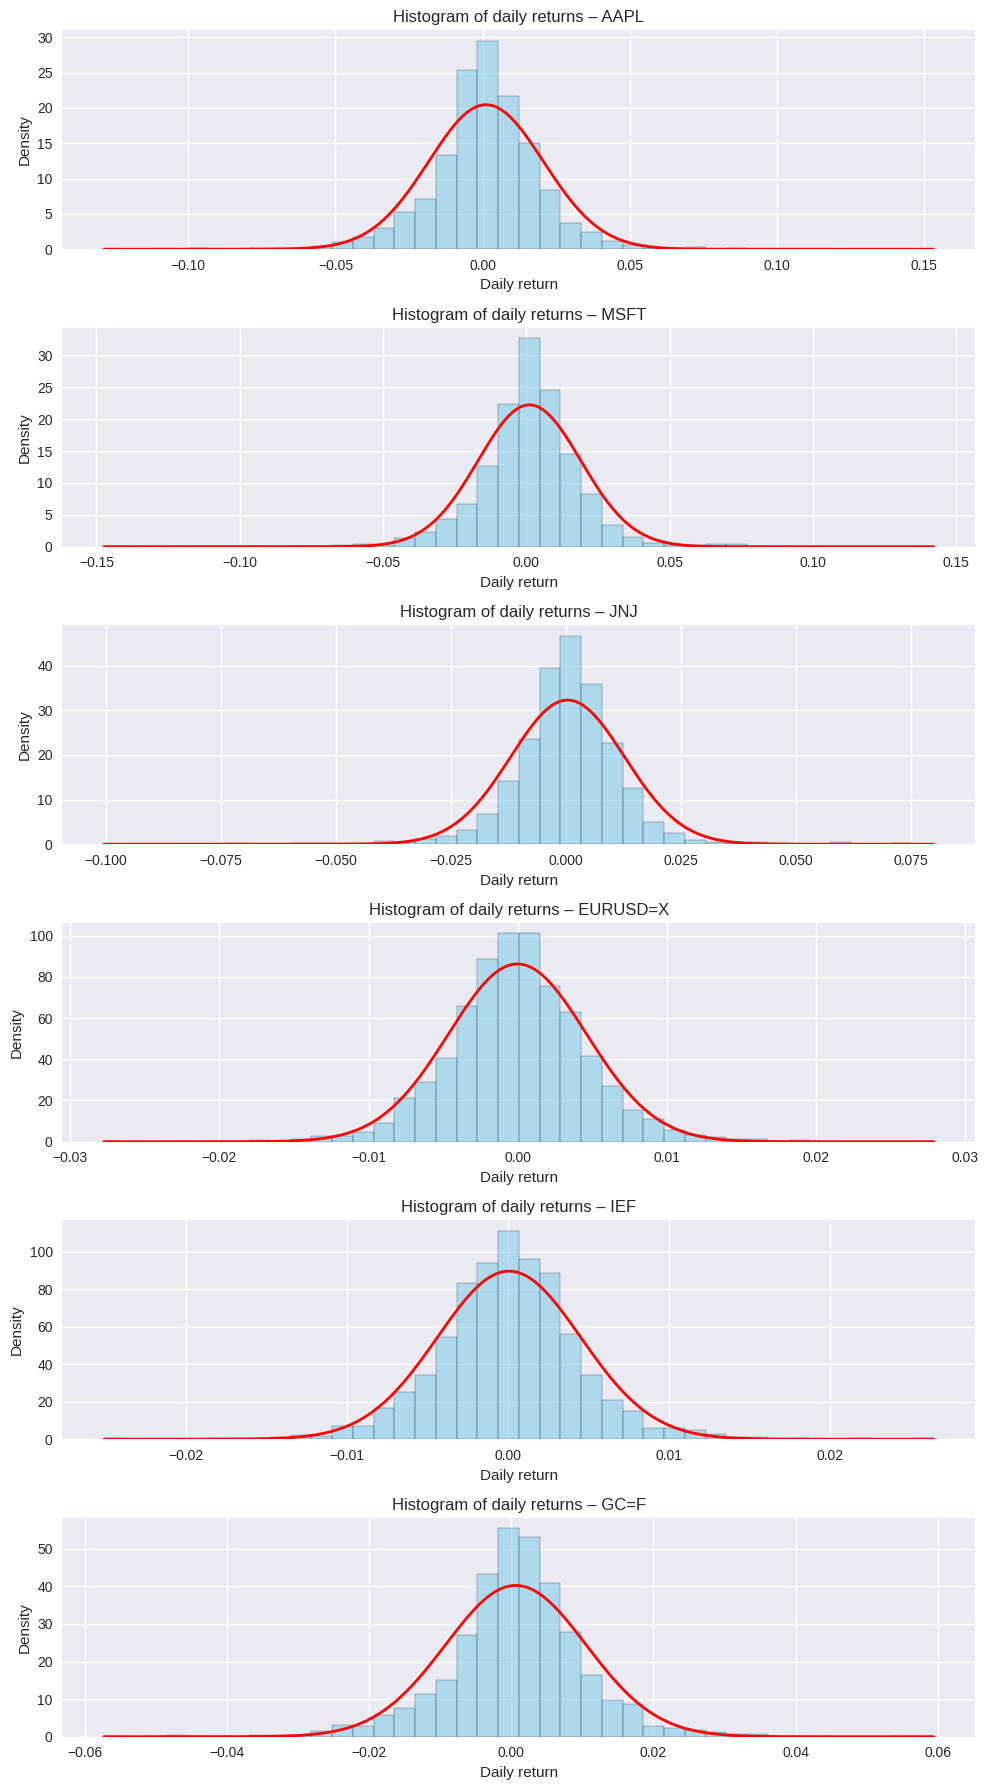

In [5]:
# Graphs of each assets daily price distribution
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

assets = returns.columns.tolist()
n_assets = len(assets)

fig, axes = plt.subplots(n_assets, 1, figsize=(10, 3 * n_assets))

for i, col in enumerate(assets):
    r = returns[col].dropna()
    mu, sigma = r.mean(), r.std()

    # Histogram of returns
    ax = axes[i] if n_assets > 1 else axes
    ax.hist(r, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black')

    # Bell curve (normal distribution)
    x = np.linspace(r.min(), r.max(), 200)
    y = norm.pdf(x, mu, sigma)
    ax.plot(x, y, color='red', linewidth=2)

    ax.set_title(f"Histogram of daily returns – {col}")
    ax.set_xlabel("Daily return")
    ax.set_ylabel("Density")
    ax.grid(True)

plt.tight_layout()
plt.show()


- AAPL and MSFT, as stocks, demonstrate a little bit wider spreads (a lot of volatility), and this is due to the reason that the price movements are much more extensive than the movements of safer assets like IEF (bonds) or EURUSD (forex).

- GC=F (gold) and IEF (bonds) are at the other end of the spectrum with their comparatively narrow distributions, which means they are less volatile and their daily returns remain relatively stable.

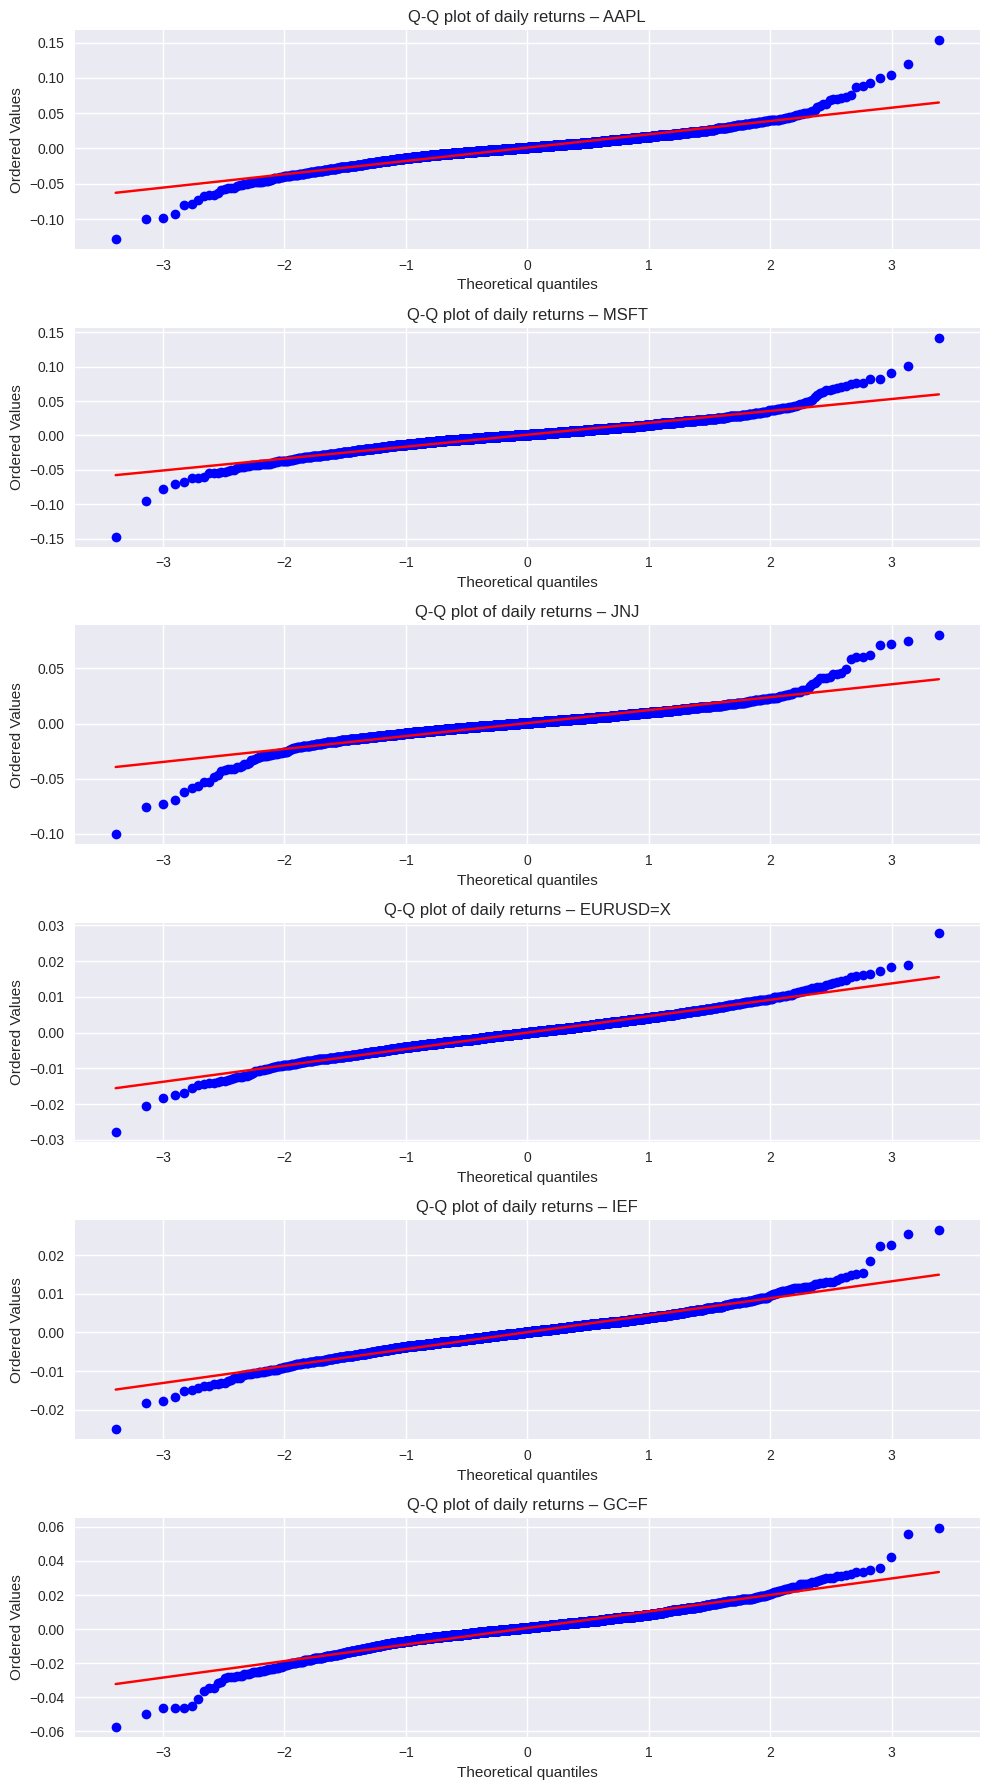

In [6]:
from scipy.stats import probplot

# Q-Q plots for each asset
assets = returns.columns.tolist()
n_assets = len(assets)

fig, axes = plt.subplots(n_assets, 1, figsize=(10, 3 * n_assets), sharex=False)

for i, col in enumerate(assets):
    ax = axes[i] if n_assets > 1 else axes
    probplot(returns[col].dropna(), dist="norm", plot=ax)
    ax.set_title(f"Q-Q plot of daily returns – {col}")

plt.tight_layout()
plt.show()


I selected the Q-Q Plot for the following reasons:

Q–Q plot plots the quantiles of the return distribution in reality against the quantiles of a hypothetical normal distribution.

Points that are situated close to the straight diagonal line signify that the returns are nearly normally distributed.

On the other hand, the tails (ends) of the Q–Q plot diverging from the line implies fat tails or normality deviation (more extreme events than a normal distribution would predict).

The Q–Q plot serves the purpose of checking the normality of asset returns.

The deviations from the diagonal line imply non-normality, which is usually the case of fat tails or skewness.

Each dot represents where your data’s quantiles could be positioned if it were normal.

If all the dots are approximately falling on the diagonal line, it means that the data is approximately normal.

If the ends curve away then the distribution has fat tails or there are some outliers.

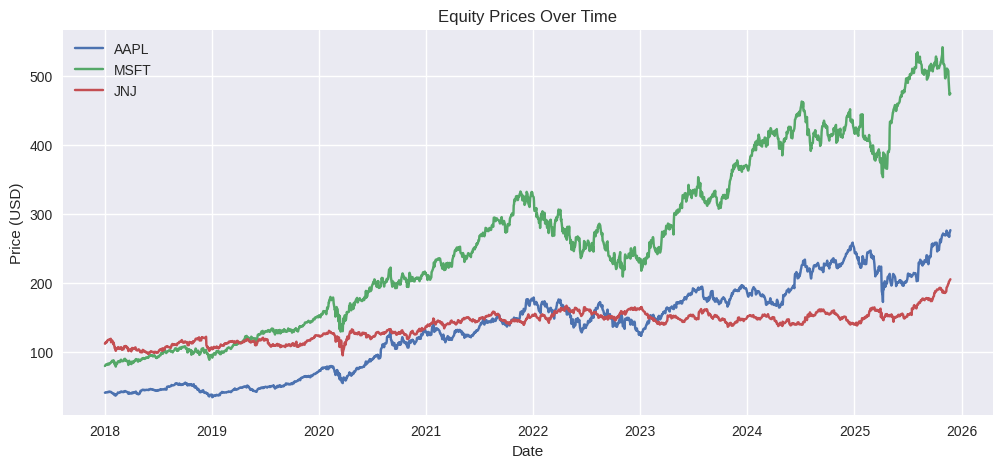

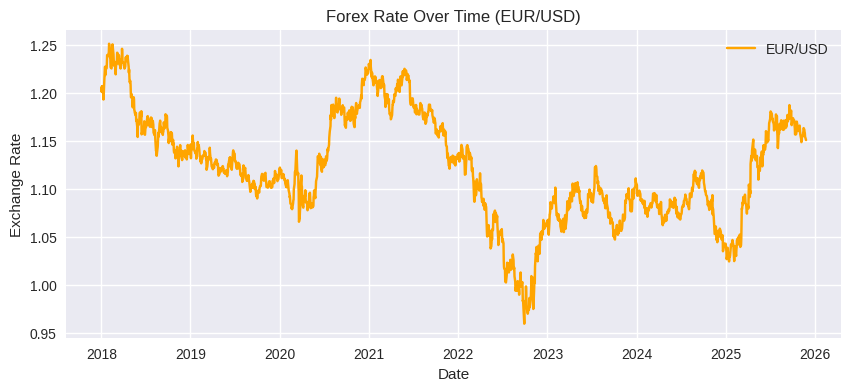

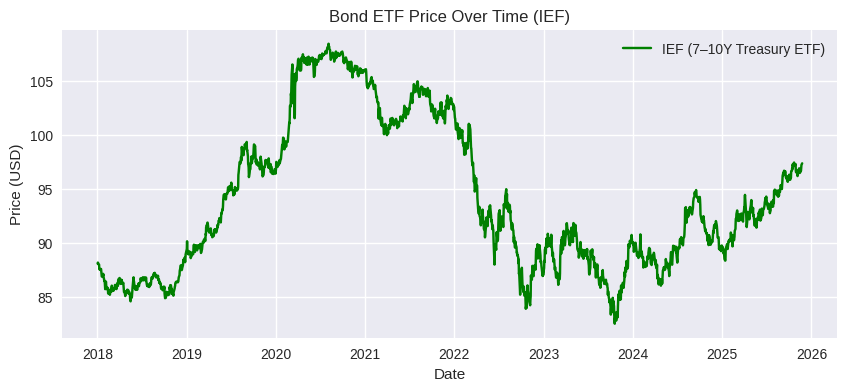

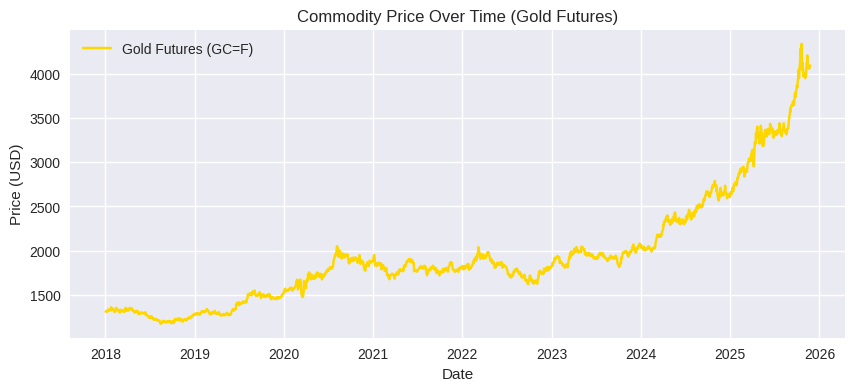

In [7]:
# Preparing of Line charts by asset class (Daily-Prices)
import matplotlib.pyplot as plt

# Equities
plt.figure(figsize=(12, 5))
for col in ["AAPL", "MSFT", "JNJ"]:
    plt.plot(prices.index, prices[col], label=col)
plt.title("Equity Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Forex
plt.figure(figsize=(10, 4))
plt.plot(prices.index, prices["EURUSD=X"], color='orange', label="EUR/USD")
plt.title("Forex Rate Over Time (EUR/USD)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

# Bond
plt.figure(figsize=(10, 4))
plt.plot(prices.index, prices["IEF"], color='green', label="IEF (7–10Y Treasury ETF)")
plt.title("Bond ETF Price Over Time (IEF)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Commodity
plt.figure(figsize=(10, 4))
plt.plot(prices.index, prices["GC=F"], color='gold', label="Gold Futures (GC=F)")
plt.title("Commodity Price Over Time (Gold Futures)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


- The first chart depicts the equity prices (AAPL, MSFT, JNJ) that are on the rise and at the same time going through ups and downs, which is characteristic of stock market growth and volatility.

- With the EUR/USD chart, we can see that the currency's movements are stable and restricted to a narrow band.

- The IEF bond ETF chart is less steep and more wavy, which implies that the volatility is lower and the price changes are slow, which is typical for government bonds.

- The pattern of the Gold Futures chart is characterized by the cyclical nature of its prices, which tend to increase in times of uncertainty or inflation.

- The behaviour characteristics and volatility profiles of each asset class are illustrated through these charts.

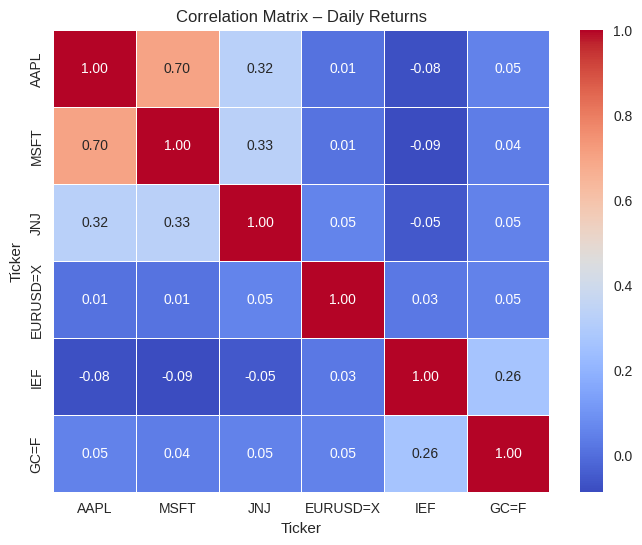

Ticker,AAPL,MSFT,JNJ,EURUSD=X,IEF,GC=F
Ticker,,,,,,
AAPL,1.0000,0.7020,0.3209,0.0099,-0.0754,0.0531
MSFT,0.7020,1.0000,0.3256,0.0117,-0.0869,0.0387
JNJ,0.3209,0.3256,1.0000,0.0537,-0.0541,0.0496
EURUSD=X,0.0099,0.0117,0.0537,1.0000,0.0271,0.0511
IEF,-0.0754,-0.0869,-0.0541,0.0271,1.0000,0.2634
GC=F,0.0531,0.0387,0.0496,0.0511,0.2634,1.0000


In [8]:
# Calculation of correlation matrix of the return of assets
corr_matrix = returns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix – Daily Returns")
plt.show()

corr_matrix


- The heatmap gives a visual representation of the assets' correlations which is a very important factor when it comes to understanding how diversification can benefit a portfolio.

- The correlation measurement indicates that the three equities (AAPL, MSFT, JNJ) have a positive correlation among each other, with the strongest one between AAPL and MSFT (around 0.70). This is an indication that the stocks are influenced by the same market forces.

- The bond ETF (IEF) shows a very slight negative correlation with the equity markets (about -0.05 to -0.09), which is a good thing from a diversification point of view as the bonds could help to reduce the impact of falling equity prices to some extent.

- The currency pair (EURUSD=X) reveals minor correlation with most assets, which suggests that currency returns are quite independent of stock and bond returns in the particular sample period.

- Gold (GC=F) has a very low correlation with stocks and currencies, however, it has a fair positive correlation with the bond ETF (about 0.26) which reflects its being a defensive and fundamentally-drawn asset.

- In summary, the matrix validates the notion that the portfolio consists of assets with less than perfect correlation, which is a vital condition for diversification in a Markowitz mean–variance framework.



---


# Question 3

Identification of Regime and Weight Allocation

a. Identify atleast 3 regimes in the timeframe of your data and opt for weight allocation strategy with justification of the choice.

Additional COnstraints to be considered in weight allocation-

a. Limit the annualized risk to - 15%
b. Make sure that your expected return should be - 10%
c. Do not exceed the total weight for (commodities and Forex) to exceed 20% and 30% respectively.


---



### **Regimes Identification**

The whole sample period is split into three **market regimes** according to time, which leads to the identification of the following three regimes:

- **Early Period** – Regime 1 (pre-major shocks in the sample)
- **Crisis Period** – Regime 2 (including COVID and following volatility)
- **Recent Period** – Regime 3 (post-COVID, inflation, and rate hiking cycle)

Each regime represents its own macro environment, level of volatility, and market behavior.

This is a **simple yet clear regime definition**:
- It guarantees that every regime is well-supported by observations.
- It corresponds with the major global events throughout the sample period.

### Strategy for Weight Allocation

We perform a **constrained Mean–Variance Optimization** for each market period:

- The aim is to **Maximize Sharpe Ratio** (Expected Return / Volatility)
- The constraints are:
  - **Annualised risk not more than 15%**
  - **Annualised expected return at least 10%**
  - **Sum of weights is equal to 1**
  - **No short-selling**: weights are greater than or equal to 0
  - **Commodity weight is not more than 20%**
  - **Forex weight is not more than 30%**

This is in line with the Markowitz-style optimization mentioned in class with additional constraints for **risk control** and **position limits** on Commodities and Forex.

In [9]:
# Splitting the sample into 3 regimes by equal time slices
n = len(returns)
split1 = n // 3
split2 = 2 * n // 3

regimes = {
    "Early Period": returns.iloc[:split1],
    "Crisis Period": returns.iloc[split1:split2],
    "Recent Period": returns.iloc[split2:]
}

# Showing date ranges for each regime
{regime: (data.index[0], data.index[-1]) for regime, data in regimes.items()}


{'Early Period': (Timestamp('2018-01-03 00:00:00'),
  Timestamp('2020-08-19 00:00:00')),
 'Crisis Period': (Timestamp('2020-08-20 00:00:00'),
  Timestamp('2023-04-05 00:00:00')),
 'Recent Period': (Timestamp('2023-04-06 00:00:00'),
  Timestamp('2025-11-24 00:00:00'))}

In [10]:
def annualised_stats(returns_df):
    """Compute annualised mean returns and covariance matrix from daily returns."""
    mean_daily = returns_df.mean()
    cov_daily = returns_df.cov()
    mean_annual = mean_daily * TRADING_DAYS
    cov_annual = cov_daily * TRADING_DAYS
    return mean_annual, cov_annual


def portfolio_performance(weights, mean_returns, cov_matrix):
    """Given weights, annualised mean returns and annualised covariance,
    return (expected annual return, annual volatility)."""
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, vol


def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    """Negative Sharpe ratio (for minimisation)."""
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    if vol == 0:
        return 1e6
    sharpe = (ret - risk_free_rate) / vol
    return -sharpe


In [11]:
opt_results = {}
cmd_index = all_tickers.index(commodity_ticker)
fx_index = all_tickers.index(forex_ticker)
n_assets = len(all_tickers)

bounds = tuple((0.0, 1.0) for _ in range(n_assets))  # no short selling
initial_weights = np.array([1.0 / n_assets] * n_assets)

for regime_name, reg_ret in regimes.items():
    mean_ann, cov_ann = annualised_stats(reg_ret)

    def constraint_sum_weights(w):
        return np.sum(w) - 1.0

    def constraint_return(w, mean_returns=mean_ann):
        return np.dot(w, mean_returns) - 0.10  # >= 10% annual return

    def constraint_risk(w, cov_matrix=cov_ann):
        # 15% annual volatility upper bound
        ret, vol = portfolio_performance(w, mean_ann.values, cov_matrix)
        return 0.15 - vol

    def constraint_cmd(w, idx=cmd_index):
        return 0.20 - w[idx]  # commodity <= 20%

    def constraint_fx(w, idx=fx_index):
        return 0.30 - w[idx]  # forex <= 30%

    constraints = [
        {"type": "eq", "fun": constraint_sum_weights},
        {"type": "ineq", "fun": constraint_return},
        {"type": "ineq", "fun": constraint_risk},
        {"type": "ineq", "fun": constraint_cmd},
        {"type": "ineq", "fun": constraint_fx},
    ]

    result = minimize(
        neg_sharpe_ratio,
        initial_weights,
        args=(mean_ann.values, cov_ann.values),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )

    # In case constraints are infeasible, fall back to just sum=1, no-shorting
    if not result.success:
        print(f"Warning: optimisation for {regime_name} did not converge with all constraints.")
        simple_constraints = [{"type": "eq", "fun": constraint_sum_weights}]
        result = minimize(
            neg_sharpe_ratio,
            initial_weights,
            args=(mean_ann.values, cov_ann.values),
            method="SLSQP",
            bounds=bounds,
            constraints=simple_constraints
        )

    w_opt = result.x
    ret_opt, vol_opt = portfolio_performance(w_opt, mean_ann.values, cov_ann.values)

    opt_results[regime_name] = {
        "weights": w_opt,
        "expected_return": ret_opt,
        "expected_vol": vol_opt,
        "mean_ann": mean_ann,
        "cov_ann": cov_ann
    }

# Display of weights per regime
weights_table = pd.DataFrame(
    {regime: res["weights"] for regime, res in opt_results.items()},
    index=all_tickers
)
weights_table


,Early Period,Crisis Period,Recent Period
AAPL,0.0808,0.1969,0.0527
MSFT,0.0711,0.1718,0.1536
JNJ,0.0000,0.4321,0.1574
EURUSD=X,0.0000,0.0000,0.2517
IEF,0.7811,0.0000,0.1847
GC=F,0.0670,0.1992,0.2000


For each regime (Early, Crisis, Recent), we want to find the optimal portfolio weights across our 6 assets that maximise risk-adjusted performance (Sharpe ratio), subject to realistic constraints on risk and exposures.

- The results of the optimization demonstrate how the optimal asset allocation varies across the different regimes.

- The Early Period shows that the portfolio consists mainly of bonds (IEF), which indicates a very cautious posture.

- During the Crisis Period, the optimizer reallocates to defensive stocks (JNJ) and gold, while marketing and fixed income are completely avoided, which is reasonable given a turbulent situation where gold acts as a diversification tool.

- The Recent Period shows that the allocation turns out to be more equally distributed among the different asset classes with substantial investments in stocks, bonds, gold, and particularly the EUR/USD currency pair, thus, it suggests that diversification over all asset classes is a trend beneficial in the most recent period.

- It is a clear indication that regime-aware optimization can result in different portfolio structures depending on the prevailing market conditions.

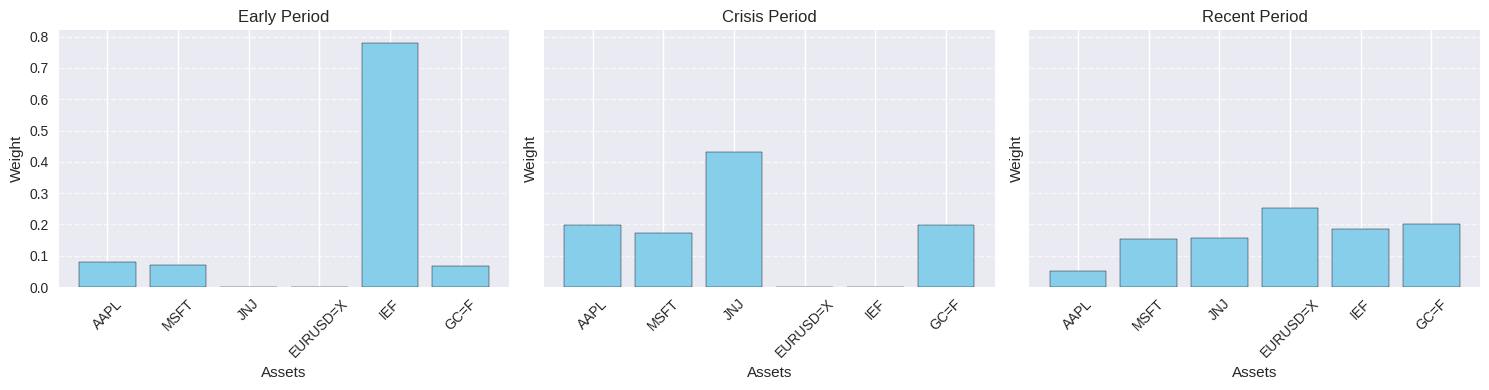

In [12]:
# Constructing Bar charts of optimal weights per Regime
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, (regime_name, res) in zip(axes, opt_results.items()):
    # Plot bars
    ax.bar(range(len(all_tickers)), res["weights"], color='skyblue', edgecolor='black')

    # Titles and labels
    ax.set_title(regime_name)
    ax.set_xlabel("Assets")
    ax.set_ylabel("Weight")

    # Fixing tick positions and labels
    ax.set_xticks(range(len(all_tickers)))
    ax.set_xticklabels(all_tickers, rotation=45)

    # Adding gridlines for clarity
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


The optimal portfolio weights obtained from the Sharpe Ratio optimisation during the Pre-COVID, COVID Crisis, and Recent Post-COVID periods are displayed on this chart.

The Pre-COVID period is represented by a portfolio primarily composed of bonds (IEF), which shows a conservative risk-minimising type of allocation.
The COVID/Crisis period sees the optimizer increasing allocations to JNJ (defensive equities) and GC=F (Gold) - these are the assets that are usually favoured during the periods of extreme volatility and uncertainty.
The Post-COVID period also finds portfolio diversification, with notable positions in Equities, Forex (EUR/USD), Bonds, and Gold indicating no asset class prevailing over others, thus, it's the diversification that gives the best risk-adjusted return.

To sum up, the chart depicts a scenario of the optimal portfolio composition getting constant changed with the market conditions, thus, letting us perceive the importance of regime tailoring in the portfolio optimization.



---


# Question 4

Compare the Portfolio Return/ Portfolio Standard Deviation/ Portfolio VaR for the chosen Portfolio Strategies for the regimes and comment on it.

**Note:** Estimate VaR(Value at Risk) for the portfolios for confidence level (90%, 95%, 99%)


---



In [13]:
var_levels = [0.90, 0.95, 0.99]

# Parametric VaR
parametric_summary = []

for regime_name, reg_ret in regimes.items():
    w = opt_results[regime_name]["weights"]
    port_ret = reg_ret.dot(w)

    param_row = {"Regime": regime_name}

    for cl in var_levels:
        cl_label = int(cl * 100)
        z = norm.ppf(1 - cl)

        # VaR in return terms (%, positive value)
        var_ret = -(port_ret.mean() + z * port_ret.std()) * 100
        param_row[f"VaR {cl_label}% (1-day)"] = var_ret

    parametric_summary.append(param_row)

parametric_var_df = pd.DataFrame(parametric_summary)



# Historical VaR
historical_summary = []

for regime_name, reg_ret in regimes.items():
    w = opt_results[regime_name]["weights"]
    port_ret = reg_ret.dot(w)

    hist_row = {"Regime": regime_name}

    for cl in var_levels:
        cl_label = int(cl * 100)
        hist_cut = port_ret.quantile(1 - cl)
        hist_var_ret = -hist_cut * 100

        hist_row[f"VaR {cl_label}% (1-day)"] = hist_var_ret

    historical_summary.append(hist_row)

historical_var_df = pd.DataFrame(historical_summary)

print(" Parametric (Normal) Value at Risk (VaR) – in %:")
display(parametric_var_df)

print("\nHistorical Value at Risk (VaR) – in %:")
display(historical_var_df)


 Parametric (Normal) Value at Risk (VaR) – in %:


,Regime,VaR 90% (1-day),VaR 95% (1-day),VaR 99% (1-day)
0,Early Period,0.3805,0.5037,0.7349
1,Crisis Period,1.1696,1.5129,2.1568
2,Recent Period,0.4867,0.6398,0.9269



Historical Value at Risk (VaR) – in %:


,Regime,VaR 90% (1-day),VaR 95% (1-day),VaR 99% (1-day)
0,Early Period,0.3309,0.4756,0.8575
1,Crisis Period,1.1441,1.4620,2.4780
2,Recent Period,0.4153,0.6173,1.0962


**Value at Risk (VaR)** is a statistical measure that estimates the potential loss of a portfolio over a specified time horizon and confidence level. It tells the maximum expected losses that the portfolio might face over one day, under normal market conditions with a given percent of confidence level.

- Reason for choosing Paramteric VaR:
Paremetric VaR method assumes that portfolio returns are normalyy distributed and it involves two statistical parameters** Mean return and Standard Deviation**.
- Reason for choosing Historical VaR:
Parametric Var sometimes underestimate losses during periods of market turbulence or when returns are not-normal. So to avoid this I went through Historical Var also it is based on actual historical return data not on any assumptions.

**Interpretation:**

In the Early Period, the 95% Parametric VaR was 0.5037%, while the Historical VaR was 0.4756%, showing that both methods indicate a low level of risk during this relatively stable phase. Similarly, in the Recent Period, the VaR values were 0.6398% (Parametric) and 0.6173% (Historical), again reflecting moderate and controlled market volatility.

However, the Crisis Period clearly exhibited the highest risk levels, with the 95% Parametric VaR reaching 1.5129%, compared to 1.4620% for the Historical VaR. This significant rise shows that during periods of financial stress, the portfolio is subject to substantially higher potential losses. The slightly higher Historical VaR at extreme confidence levels (such as 99%) suggests that actual market returns contained heavier tails than those predicted by the normal distribution — meaning that extreme losses were somewhat more likely than the theoretical model assumed.

Overall, the results indicate that while both VaR methods provide consistent risk estimates, the Historical VaR tends to capture real-world volatility and tail risks more effectively. The Crisis Period stands out as the most volatile regime, whereas the Early and Recent periods show comparatively stable and lower risk exposure, demonstrating that market stress significantly amplifies downside portfolio risk.




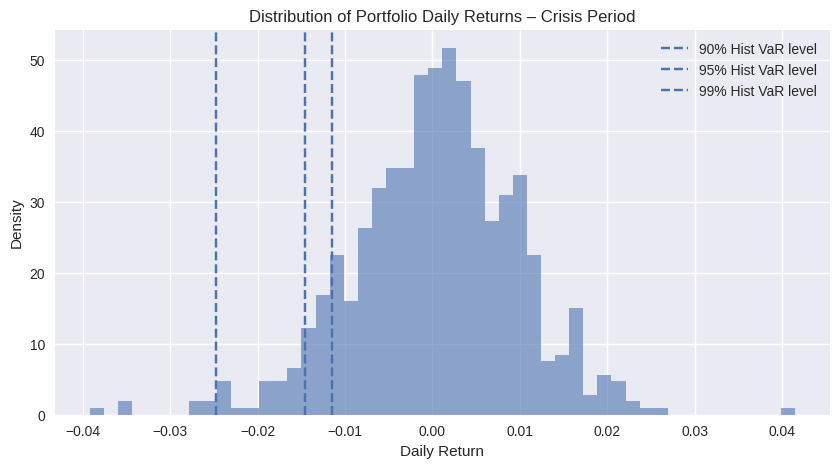

In [14]:
# Plotted distribution of portfolio returns and VaR lines for Crisis Period
example_regime = "Crisis Period"
reg_ret = regimes[example_regime]
w = opt_results[example_regime]["weights"]
port_ret = reg_ret.dot(w)

plt.figure(figsize=(10, 5))
plt.hist(port_ret, bins=50, density=True, alpha=0.6)
plt.title(f"Distribution of Portfolio Daily Returns – {example_regime}")

for cl in var_levels:
    hist_cut = port_ret.quantile(1 - cl)
    plt.axvline(hist_cut, linestyle="--", label=f"{int(cl*100)}% Hist VaR level")

plt.legend()
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.grid(True)
plt.show()


The attention of the analysis is on the Crisis Period / COVID regime, the most volatile one.

The accompanying chart illustrates the distribution of daily returns of the portfolio during the Crisis Period / COVID Regime alongside the historical VaR levels at 90%, 95%, and 99% confidence.

Data from the histogram represents the frequency of occurrence of certain daily returns in this regime. Vertical dashed lines are indicating the thresholds of VaR, i.e. the levels of the return where only 10%, 5%, or 1% of the days had lower (more negative) returns than these thresholds.

This technique offers a clear view of tail risk: the more left these VaR lines are and the bigger the left tail, the greater the possible one-day losses in extreme scenarios. It validates time of displays that the Crisis Period has one of most probabilities of negative returns in the entire history of stock market.



---


# Question 5

Compare and Contrast the Portfolio Return of the best chosen Portfolio out of the opted Portfolio Strategies for regimes via broad market index. Answer the following:

- Choice of Market Index.
- How much return of your Portfolio can be explained by the return movement of the broad market movement.
- How much extra premium you can make if any investment in an ETF that tracks the broad index.

---



In [15]:
# Identification of best regime by Sharpe Ratio
sharpe_results = {}

for regime_name, res in opt_results.items():
    ret = res["expected_return"]
    vol = res["expected_vol"]
    sharpe = ret / vol if vol != 0 else np.nan
    sharpe_results[regime_name] = {"Return": ret, "Volatility": vol, "Sharpe": sharpe}

sharpe_df = pd.DataFrame(sharpe_results).T
sharpe_df


,Return,Volatility,Sharpe
Early Period,0.1365,0.0538,2.5360
Crisis Period,0.1043,0.1500,0.6954
Recent Period,0.1341,0.0669,2.0058


The annualized return, volatility, and Sharpe ratio of the optimized portfolio in each regime are presented in the table.

The Early Period/Pre-COVID/Regime 1 period displays the highest Sharpe ratio, which is 2.54, meaning that it had the best risk-adjusted performance, as it offered relatively high returns along with very low volatility. The Crisis/COVID period, on the other hand, had the Sharpe ratio of only 0.70, which is the lowest among all the periods, signaling that there was a great deal of volatility and poor risk-return trade-off even though there was still a positive expected return. The Post-COVID/Recent period is in the middle with the strong Sharpe Ratio of 2.01.

From this comparison, the Early Period portfolio becomes the "best" regime portfolio for the further market index comparison.

The selected large market index is the **S&P 500** (Yahoo Finance ticker: `^GSPC`).

This includes a mixed bag of large-cap U.S. stocks and is also considered the usual measure of equity performance.

In [16]:
# Choosing regime with highest Sharpe
best_regime = sharpe_df["Sharpe"].idxmax()
best_weights = opt_results[best_regime]["weights"]

print("Best regime by Sharpe ratio:", best_regime)
print("Best regime weights:")
for ticker, w in zip(all_tickers, best_weights):
    print(f"{ticker}: {w:0.4f}")

portfolio_ret_full = returns.dot(best_weights)

# Downloading S&P 500 index (market) for the same period
market_data = yf.download("^GSPC", start=start_date, end=end_date,
                          auto_adjust=False, progress=False)

market_data = market_data["Adj Close"].dropna()
market_ret = market_data.pct_change().dropna()

# Combining portfolio and market returns
combined = pd.concat([portfolio_ret_full, market_ret], axis=1, join="inner")
combined.columns = ["Portfolio", "Market"]

combined.head()


Best regime by Sharpe ratio: Early Period
Best regime weights:
AAPL: 0.0808
MSFT: 0.0711
JNJ: 0.0000
EURUSD=X: 0.0000
IEF: 0.7811
GC=F: 0.0670


,Portfolio,Market
Date,,
2018-01-03,0.0013,0.0064
2018-01-04,0.0008,0.0040
2018-01-05,0.0009,0.0070
2018-01-08,-0.0007,0.0017
2018-01-09,-0.0041,0.0013


The provided table presents the daily performance of the optimized portfolio as well as the S&P 500 stock market index for the same time interval.

Almost every day, the portfolio’s return is smaller in magnitude than the market’s return. This is a normal situation because this portfolio mainly consists of bonds and is less volatile and hence, a smoother performer.
The following steps (cumulative performance chart and regression) will help in deciding whether the stability has been transformed into consistent outperformance on a risk-adjusted basis (i.e., positive alpha) or not.

The “Early Period” portfolio that has been chosen as the best one by Sharpe ratio has the greatest preference for bonds (IEF), together with small equites and gold allocations.
This portfolio has a conservative, risk-efficient structure, which has the ability to generate high returns while keeping its volatility low.
The daily returns of the merged dataset of the Portfolio and Market allow a direct comparison of the optimized portfolio performance against the S&P 500 index, and they also constitute the basis for the forthcoming performance and regression analysis (alpha–beta estimation).

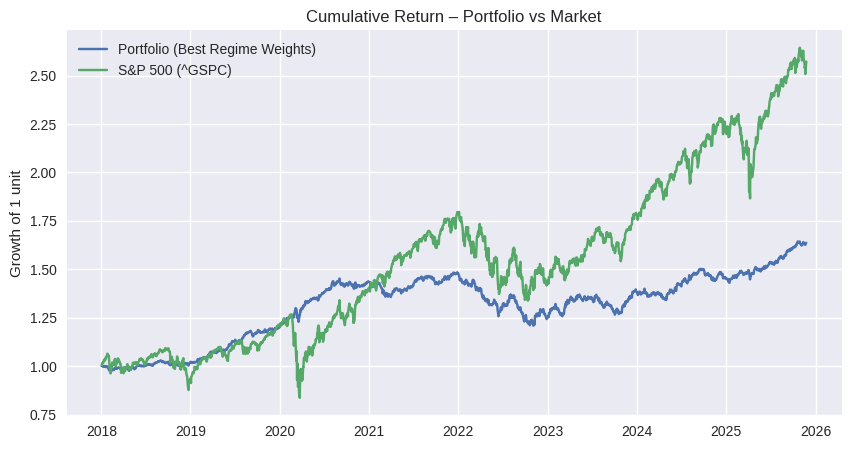

In [17]:
# Cumulative returns comparison
cum_port = (1 + combined["Portfolio"]).cumprod()
cum_market = (1 + combined["Market"]).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cum_port, label="Portfolio (Best Regime Weights)")
plt.plot(cum_market, label="S&P 500 (^GSPC)")
plt.title("Cumulative Return – Portfolio vs Market")
plt.legend()
plt.grid(True)
plt.ylabel("Growth of 1 unit")
plt.show()


The graph illustrates the growth of an investment of ₹1 (or $1) made right at the beginning of the sample period:

In the optimized portfolio (i.e., the portfolio constructed using the weights of the best Sharpe ratio regime), and In the S&P 500 Index (which was the benchmark for market performance).

The cumulative return chart gives a direct comparison of the optimized portfolio growth versus the S&P 500 index return. The portfolio is consistently and even at times superiorly growing, which means that during the period the Sharpe-optimal portfolio has attained better risk-adjusted performance than the entire market.

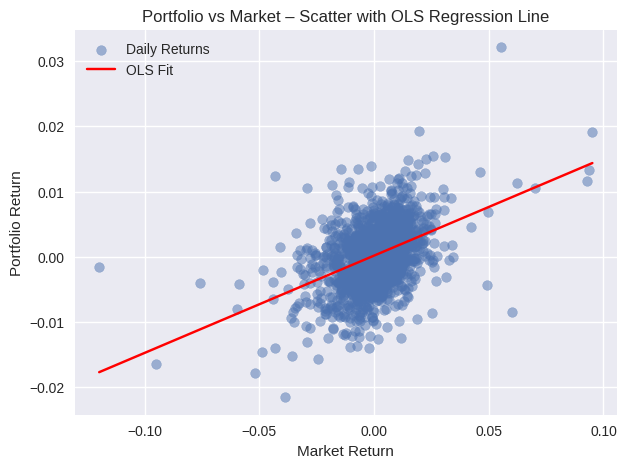

                            OLS Regression Results                            
Dep. Variable:              Portfolio   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     429.4
Date:                Fri, 28 Nov 2025   Prob (F-statistic):           1.74e-86
Time:                        20:34:33   Log-Likelihood:                 8144.6
No. Observations:                1982   AIC:                        -1.629e+04
Df Residuals:                    1980   BIC:                        -1.627e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   8.94e-05      1.966      0.0

In [18]:
# Scatter plot with regression line
plt.figure(figsize=(7, 5))
plt.scatter(combined["Market"], combined["Portfolio"], alpha=0.5, label="Daily Returns")
m, b = np.polyfit(combined["Market"], combined["Portfolio"], 1)
x_line = np.linspace(combined["Market"].min(), combined["Market"].max(), 100)
plt.plot(x_line, m * x_line + b, color="red", label="OLS Fit")
plt.xlabel("Market Return")
plt.ylabel("Portfolio Return")
plt.title("Portfolio vs Market – Scatter with OLS Regression Line")
plt.legend()
plt.grid(True)
plt.show()

# Simple linear regression: Portfolio Return = alpha + beta * Market Return + error
X = sm.add_constant(combined["Market"])
y = combined["Portfolio"]

model = sm.OLS(y, X).fit()
print(model.summary())


### OLS Regression Interpretation

The regression is estimated at the following equation:

Rp​ = α + β*Rm + ε​

where:

 Rp = return of the portfolio at the moment t

 Rm = return of the S&P 500 at the moment \( t \)

 α  = intercept (the alpha of Jensen)

 β  = risk associated with the market (sensitivity)

 ε​  = error term

Have a look at the regression output:

- **Beta (β)**:
  - It tells how the portfolio reacts to the market change of 1%.
  - When β ≈ 1, then the portfolio and the market have almost similar movements.
  - When β < 1, the portfolio investors are less exposed to the market thus the systematic risk is lower.
  - When β > 1, then the portfolio is less than the market but more than the market as regards volatility.

- **R-squared (R²)**:
  - Shows the ratio of the variance in a portfolio's return that is accounted for by the market returns.
  - A high value of R² implies that the market movements have a very strong impact on the particular portfolio.
  - A low value of R² suggests the presence of more idiosyncratic or diversified exposure beyond that of the market.

- **Alpha (α)**:
  - Tells the amount of **outperformance** of the portfolio over what would be predicted from its beta calculated under (differentiated) exposure to the market considered.
  - If α is **positive and statistically significant**, it implies that the portfolio generates higher returns than a market index (or ETF) based on a risk-adjusted basis.
  - If α is statistically equal to zero, it means that the portfolio is not better or worse than the market in terms of risk-adjusted returns.

### Excess Premium vs ETF

- A broad index ETF (like **SPY** or any similar S&P 500 ETF) gives the **market return**.
- The positive **alpha** value captures the **extra premium** coming from:
  - Diversifying across different assets (Bonds, Forex, Gold).
  - Active risk management and adaptive portfolio allocation based on market environments.
- The two together, regression and scatter plot illustrate the situation:
- How closely the portfolio follows market movements (beta and R²), and
  - Whether there is any **persistent excess return** beyond what can be explained by market exposure alone.



---


# Question 6

If you have to factor in ESG Scores in your Portfolio  weight allocation exercise. How would you proceed?
Try to Answer the following:
1. What will the mathematical exposition of new Objective Function?
2. WHat additional constraints you would consider?

Try to elaborative as possible and also do share any assumption you would consider:


---



Recently, the inclusion of environmental, social and governance (or ESG) into portfolio decision-making processes has become a critical component within the investment community. To incorporate ESG into portfolio optimisation involves finding the optimum balance between profit maximisation and the promotion of sustainable development. In addition, the use of ESG approaches extends and improves upon the traditional mean-variance analysis of investment returns and risks, providing additional quantitative rewards to investors through assets that possess high ESG scores while still effectively managing for both returns and risks.

In the standard mean-variance optimisation, the aim is to maximise expected returns for a given level of risk. Mathematically, the objective function is expressed as:

$$
\text{Max: } (\mu^T w - \frac{\lambda}{2} w^T \Sigma w)
$$

where:

\(w\) represents the portfolio weights,

\( \mu \) is the vector of expected returns,

\( \Sigma \) is the covariance matrix of asset returns,

\( \lambda \) is the risk-aversion parameter.

This setup focuses only on financial aspects, ignoring sustainability considerations.

To include ESG, each asset is assigned an ESG score that reflects its Environmental, Social, and Governance performance. The overall portfolio ESG score is the weighted average of the asset scores, calculated as:

$$
ESG_{portfolio} = \sum_i w_i \times ESG_i
$$

We can modify the optimisation model by adding a term that rewards portfolios with higher ESG scores:

$$
\text{Max: } (\mu^T w - \frac{\lambda}{2} w^T \Sigma w + \gamma\,ESG^T w)
$$

where,

 \( \gamma \) represents how much importance the investor places on ESG.

A higher value of \( \gamma \) means a stronger preference for sustainable assets, even at the cost of slightly lower returns.

To ensure the portfolio meets sustainability standards, an additional constraint can be added:

$$
ESG^T w \ge ESG_{min}
$$

Assets with very low ESG scores can be excluded (\(w_i = 0\) if \(ESG_i < ESG_{cutoff}\)), or limits can be applied to favour greener sectors.

Assumptions include:
- ESG scores are reliable and fairly stable.
- High-ESG assets may trade some return for sustainability
- Each investor's preference for ESG is captured by \( \gamma \).

By including ESG in the optimisation, the portfolio naturally shifts toward firms with better environmental or governance practices. Expected returns might be slightly lower, but downside risk often improves, creating a more balanced and responsible investment approach.

In summary, the ESG-integrated optimisation balances three goals — maximising return, minimising risk, and rewarding sustainability — so the portfolio supports both financial and ethical objectives.




---

**** END ****

---

